# Hubble Diagram
In this notebook we are going to fit a cosmological model ($\Lambda$-CDM for the moment) to a set of luminosity distances $D_L$ and redshift $z$ data from simulated gravitational (GW) events. The data is representative of the expected 1-year observatiosn by Einstein Telescope (ET).

In [17]:
# read GW data
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
from scipy.optimize import curve_fit

with h5py.File('nsns_population_joan.hdf5', 'r') as table:
    print(table.keys())
    dl_unsorted = table['dL'][()]
    z_unsorted = table['z'][()]
    dl_err_unsorted = table['deldL'][()]

<KeysViewHDF5 ['Eiso', 'Epeak', 'dL', 'deldL', 'det_KN', 'det_jet', 'iota', 'm1', 'm2', 'z']>


In [37]:
# Get sorted indices based on array 'a'
sorted_indices = np.argsort(z_unsorted)

# Apply the sorting to both arrays
z = z_unsorted[sorted_indices]
dl = dl_unsorted[sorted_indices]
#dl_err = dl_err_unsorted[sorted_indices]
dl_err = 0.01*dl # 5% of actual value

[ 67.36096501 110.2403068  122.48145859 129.69499957 175.33955185]
[0.67360965 1.10240307 1.22481459 1.29695    1.75339552]
[0.01 0.01 0.01 0.01 0.01]
0


(array([    0.,     0.,     0.,     0.,     0., 11571.,     0.,     0.,
            0.,     0.]),
 array([-2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5]),
 <BarContainer object of 10 artists>)

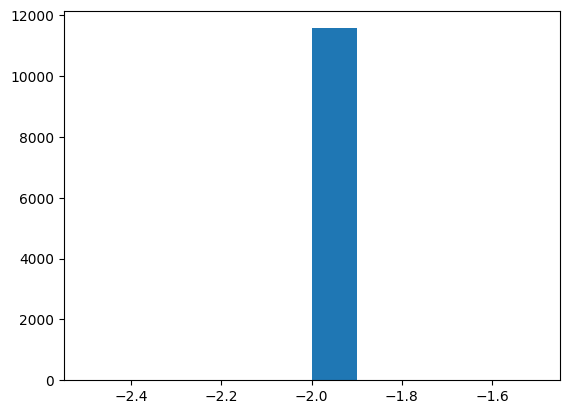

In [38]:
print(dl[0:5])
print(dl_err[0:5])
print(dl_err[0:5]/dl[0:5])
rel_err = dl_err/dl
count = 0
for val in rel_err:
    if val >= 1:
        count+=1
print(count)


plt.hist(np.log10(dl_err/dl))

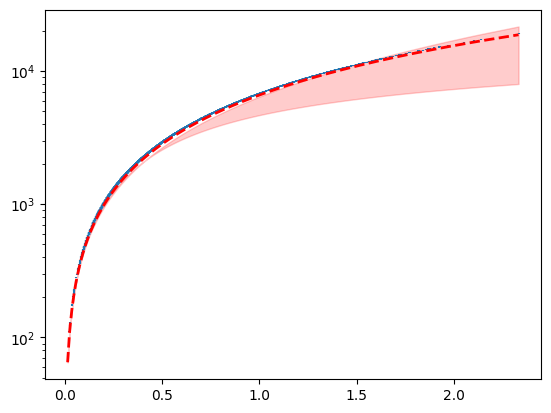

In [40]:
standard = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
upper = LambdaCDM(H0=70, Om0=2.0, Ode0=2.0)
lower = LambdaCDM(H0=70, Om0=0.0, Ode0=0.0)

plt.figure()
plt.errorbar(z, dl, dl_err, fmt='none')
plt.plot(z, standard.luminosity_distance(z), linewidth=2, c='r', linestyle='--')
plt.fill_between(z, lower.luminosity_distance(z).value, upper.luminosity_distance(z).value, color='r', alpha=0.2)
plt.yscale('log')
#plt.ylim(1e-3, 1e5)

In [41]:
# Parameter ranges
Om = np.linspace(0.1, 2.0, 25)
Ode = np.linspace(0.1, 2.0, 25)

# Calculate chi-square surface
chi_surface = np.zeros([len(Om), len(Ode)])
mask = np.zeros([len(Om), len(Ode)])

factor = 1
extra = np.log10(factor)
total_err = dl_err + extra

def model(x, a, b):
    cosmo = LambdaCDM(H0=70, Om0=a, Ode0=b)
    return cosmo.luminosity_distance(x).value

popt, pcov = curve_fit(model, z, dl, p0=[1.0, 1.0], bounds=([0.0, 0.0], [2.0, 2.0]), sigma=total_err)
Om_fit, Ode_fit = popt

for i in range(len(Om)):
    for j in range(len(Ode)):
        cosmo = LambdaCDM(H0=70, Om0=Om[i], Ode0=Ode[j])
        model = cosmo.luminosity_distance(z).value
        if np.isnan(model).any():
            mask[i,j] = True
            chi_surface[i,j] = 1e4
            continue

        residuals = dl - cosmo.luminosity_distance(z).value
        dof = len(z)-2
        chi_surface[i,j] = np.sum((residuals/total_err)**2)/dof


masked_chi_surface = np.ma.array(chi_surface, mask=mask)

# Find best fit parameters
print(f"Best fit parameters: Om = {Om_fit:.2f}, Ode = {Ode_fit:.2f}")

min_chi = np.nanmin(masked_chi_surface)
Om_id, Ode_id = np.unravel_index(np.nanargmin(masked_chi_surface), masked_chi_surface.shape)
Om_manual_fit, Ode_manual_fit = Om[Om_id], Ode[Ode_id]
print(Om_manual_fit, Ode_manual_fit, min_chi)

Best fit parameters: Om = 0.34, Ode = 0.91
0.3375 0.8916666666666666 0.6242227803696961


In [42]:
chi_surface

array([[5.66847708e+01, 4.20053107e+01, 2.92877424e+01, 1.89200576e+01,
        1.13790331e+01, 7.25681051e+00, 7.29786211e+00, 1.24515652e+01,
        2.39489388e+01, 4.34180991e+01, 7.30643334e+01, 1.15963297e+02,
        1.76563659e+02, 2.61602059e+02, 3.81863584e+02, 5.55266644e+02,
        1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 1.00000000e+04,
        1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 1.00000000e+04,
        1.00000000e+04],
       [7.98454735e+01, 6.27612973e+01, 4.71523188e+01, 3.32976843e+01,
        2.15341492e+01, 1.22711884e+01, 6.01114045e+00, 3.37648172e+00,
        5.14738415e+00, 1.23144203e+01, 2.61540688e+01, 4.83393124e+01,
        8.11053218e+01, 1.27502326e+02, 1.91782035e+02, 2.79947408e+02,
        4.00188713e+02, 5.60760502e+02, 1.00000000e+04, 1.00000000e+04,
        1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 1.00000000e+04,
        1.00000000e+04],
       [1.06524881e+02, 8.76856436e+01, 6.99725821e+01, 5.35932814e+01,
        3.8794

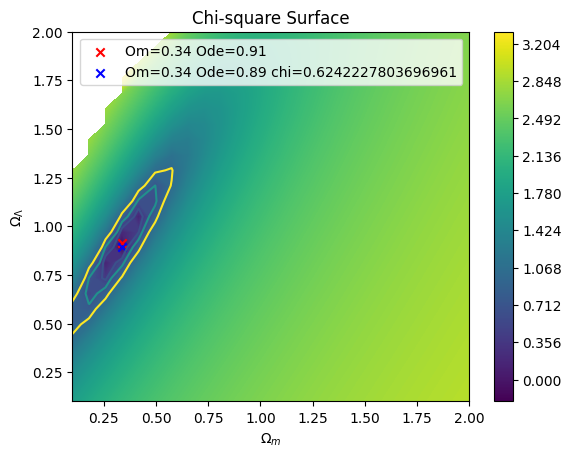

In [43]:
# Plot contour
plt.figure()
im = plt.contourf(Om, Ode, np.log10(masked_chi_surface.T), levels=1000)
plt.colorbar(im)
plt.contour(Om, Ode, masked_chi_surface.T, levels=[min_chi, min_chi+2.3, min_chi+4.61, min_chi+9.21])#, linestyles=['solid','dashed','dotted'])
plt.scatter(Om_fit, Ode_fit, marker='x', c='r', label=f'Om={Om_fit:.2f} Ode={Ode_fit:.2f}')
plt.scatter(Om_manual_fit, Ode_manual_fit, marker='x', c='b', label=f'Om={Om_manual_fit:.2f} Ode={Ode_manual_fit:.2f} chi={min_chi}')

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Chi-square Surface')
#plt.xlim(0.45,0.65)
#plt.ylim(1.0, 1.25)
plt.legend()
plt.show()

In [6]:
np.save('GW_chi_surface.npy', chi_surface)
np.save('GW_mask.npy', mask)